# Importing Data

In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [26]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/housing-classification-iter-0-2.csv')

In [20]:
houses.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
Expensive         0
dtype: int64

In [21]:
houses.describe().round(2)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,10516.83,70.05,1057.43,2.87,0.61,2.76,1.77,94.24,15.06,0.15
std,9981.26,24.28,438.71,0.82,0.64,40.18,0.75,125.34,55.76,0.36
min,1300.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7553.50,59.00,795.75,2.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,9478.50,69.00,991.50,3.00,1.00,0.00,2.00,0.00,0.00,0.00
75%,11601.50,80.00,1298.25,3.00,1.00,0.00,2.00,168.00,0.00,0.00
max,215245.00,313.00,6110.00,8.00,3.00,738.00,4.00,857.00,480.00,1.00


In [22]:
houses.sort_values(by='BedroomAbvGr', ascending=False)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
635,10896,60.0,1440,8,0,0,0,0,0,0
570,13101,74.0,1728,6,0,0,2,0,0,0
1350,11643,91.0,1248,6,0,0,4,0,0,0
291,5687,55.0,780,6,0,0,0,0,0,0
144,9100,70.0,1728,6,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1163,12900,60.0,1198,0,0,0,2,120,0,0
53,50271,68.0,1842,0,1,0,3,857,0,1
189,4923,41.0,1593,0,1,0,2,0,224,1
634,6979,64.0,1056,0,0,0,2,264,0,0


# Train-Test Split

In [47]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

# Handle Missing Values

In [48]:
columns = X_train.columns
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
X_train_imputed = imp.transform(X_train)
X_test_imputed = imp.transform(X_test)
X_train = pd.DataFrame(X_train_imputed, columns=columns )
X_test = pd.DataFrame(X_test_imputed, columns=columns)

In [49]:
X_train.isna().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
WoodDeckSF      0
ScreenPorch     0
dtype: int64

In [50]:
X_test.isna().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
WoodDeckSF      0
ScreenPorch     0
dtype: int64

# Z_Score Model

We assume that the more above average a house is across these features, the more likely it is to be expensive.

In [51]:
def above_average(row):
    z_score = (row-X_train.mean())/X_train.std()
    if z_score.sum() > 5:
        return 1
    else:
        return 0
    
predicted_expensive_train = X_train.apply(above_average, axis = 1) 
# The magic is in the .apply() method. When you use DataFrame.apply(func, axis=1), it applies the function func to each row of the DataFrame.
#For each row, the function computes the Z-Score. The axis=1 argument tells apply to operate row-wise. 
#If you used axis=0, it would operate column-wise.
predicted_expensive_test = X_test.apply(above_average, axis = 1)
#The apply() method creates a new pandas Series that collects each return value from the function for each row it processes. 
#This is then stored in the variable you assign the result to, such as predicted_expensive_train or predicted_expensive_test.

In [52]:
print("Training Accuracy:", accuracy_score(y_train, predicted_expensive_train))
print("Testing Accuracy:", accuracy_score(y_test, predicted_expensive_test))

Training Accuracy: 0.8707191780821918
Testing Accuracy: 0.910958904109589


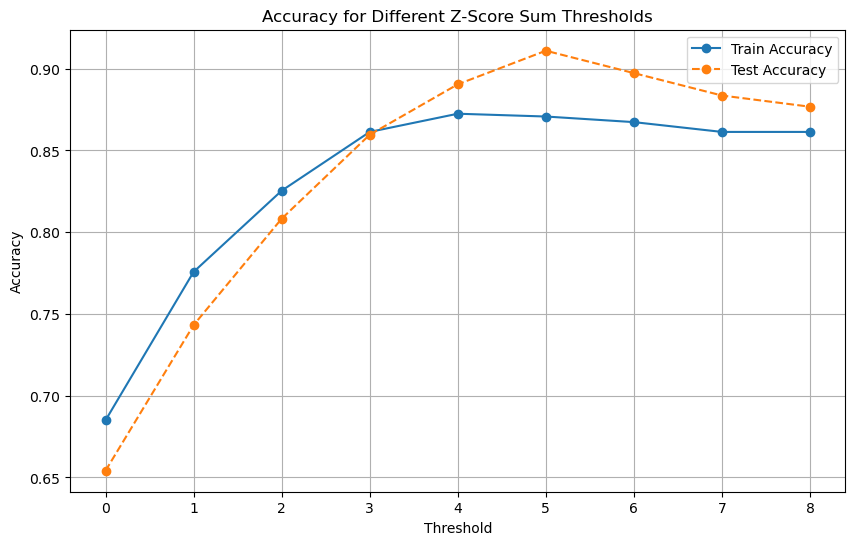

In [53]:
# Intuitive classifier function based on a threshold
def intuitive_classifier(row, threshold):
    z_scores = (row - X_train.mean()) / X_train.std()
    if z_scores.sum() > threshold:
        return 1
    return 0

# Compute accuracies for different thresholds
thresholds = list(range(0, 9))  # Thresholds from 0 to 8
train_accuracies = []
test_accuracies = []

for threshold in thresholds:
    y_pred_train = X_train.apply(intuitive_classifier, axis=1, threshold=threshold)
    y_pred_test = X_test.apply(intuitive_classifier, axis=1, threshold=threshold)
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(thresholds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(thresholds, test_accuracies, marker='o', linestyle='--', label='Test Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Z-Score Sum Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# Coding Rules - Model

In [ ]:
for column in houses.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=houses, x=column, y="Expensive", edgecolor=None, alpha=0.7)

    plt.title(f"Scatter plot of {column} and  Expensive")

    plt.show()

In [55]:
# Initialize intuitive_model with 0 for all indices in X_train
intuitive_model = pd.Series(0, index=X_train.index)

# Rule 1: Houses with GarageCars >= 3 are considered expensive
intuitive_model.loc[X_train['GarageCars'] >= 3] = 1

# Rule 2: Houses with LotArea > 12,000 sqft are considered expensive
intuitive_model.loc[X_train['LotArea'] > 12000] = 1

# Rule 3: Houses with TotalBsmtSF > 1,300 sqft are considered expensive
intuitive_model.loc[X_train['TotalBsmtSF'] > 1300] = 1

# Rule 4: Houses with Fireplaces >= 2 or PoolArea > (mean + std) are considered expensive
intuitive_model.loc[(X_train['Fireplaces'] >= 2) | (X_train['PoolArea'] > (2.76 + 40.18))] = 1

# Rule 5: Houses with BedroomAbvGr between 4 and 6 are considered expensive
intuitive_model.loc[(X_train['BedroomAbvGr'] >= 4) & (X_train['BedroomAbvGr'] <= 6)] = 1

# Rule 6: Houses with a ScreenPorch are considered expensive
intuitive_model.loc[X_train['ScreenPorch'] > 0] = 1

# Rule 7: Houses with WoodDeckSF > 200 sqft are considered expensive
intuitive_model.loc[X_train['WoodDeckSF'] > 200] = 1
intuitive_model.head()

0    0
1    1
2    1
3    1
4    0
dtype: int64

In [56]:
# Accuracy
train_accuracy = accuracy_score(y_train, intuitive_model)
train_accuracy

0.5667808219178082

In [57]:
print('This worked!')

This worked!
